In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
import numpy

In [54]:
class Node(object):
    def __init__(self, int_index=None, pos=None):
        self.int_index = int_index
        self.ext_index = None
        self.label = "Node {}".format(self.int_index)
        self.pos = pos
        #self.fp = None
        
    def __repr__(self):
        return self.label

    @property    
    def fp(self):
        fp_vec = [0]*7
        if self.int_index in (1, 2, 3):
            fp_vec[self.int_index] = 1
        else:
            fp_vec[0] = 1
            fp_vec[self.int_index] = 1
        return numpy.array(fp_vec)

# int. indices
# 1\   /5
# | 2-4 |
# 3/  \6

In [55]:
# This isn't really needed, as we end up embedding it in R^2 and using dot products for kernels...
# Good for visualisation, though.

In [56]:
import networkx as nx
import matplotlib.pyplot as plt

In [57]:
# Pos is coordinates in R^2
n1 = Node(1, pos=(1, 2))
n2 = Node(2, pos=(1, 1))
n3 = Node(3, pos=(2, 1))
n4 = Node(4, pos=(-1, -1))
n5 = Node(5, pos=(-2, -1))
n6 = Node(6, pos=(-1, -2))

edge_list = [
    (n1, n2),
    (n2, n3),
    (n3, n1),
    (n2, n4),
    (n4, n5),
    (n5, n6),
    (n6, n4)
]

G = nx.Graph()
G.add_edges_from(edge_list)

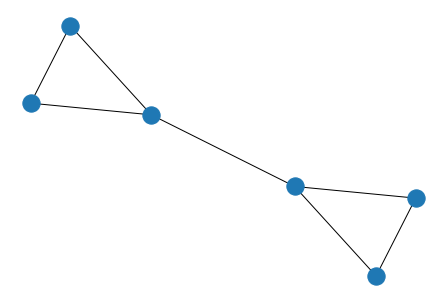

In [58]:
nx.draw(G)

In [59]:
def kernel(node1, node2):
    # path distance in the graph space (x and z) is not a kernel
    #shortest_path = nx.shortest_path(G, node1, node2)
    #return len(shortest_path) - 1
    
    # The graph is embedded in R^2 - use the gaussian for the pos. vectors
    l2 = numpy.sqrt(numpy.sum([(x - y)**2 for x, y in zip(node1.pos, node2.pos)]))
    gaussian = numpy.exp(-0.1 * l2)
    return gaussian

In [60]:
def fp_kernel(fp1, fp2):
    l2 = numpy.sqrt(numpy.sum([(x - y)**2 for x, y in zip(fp1, fp2)]))
    gaussian = numpy.exp(-0.1 * l2)
    return gaussian

In [61]:
# Start with varying lengths to force the dimensions to line up
x_input = [n1, n2, n3, n4, n5, n6]
z_input = [n1, n2, n3, n4, n5, n6]
numpy.random.shuffle(x_input)
numpy.random.shuffle(z_input)

In [62]:
# x = ms2
# z = bgc
# s(x, z) = (K_x + \lambda I_n_x)^{-1} k_x(x)^T K_y(I_x, I_z) (K_z + \lambda I_n_z)^{-1} k_z(z)
# K_x: kernel matrix in X space (dim: no. of data points in training set X)
# I_n_x: Identity matrix in the number of data points in training set X
# k_x(x): Vector of the kernel products of x with the points in the training set
# K_y(I_x, I_z): Kernel matrix with value K_y_(i, j) = k(x_i, y_j) -- i.e. the kernel products between 
#    the data points in the latent space from the two training sets

# Precomputed stuff: 
#    (K_x + \lambda I_n_x)^{-1} and similar for z
#    K_y(I_x, I_z)
# Input stuff:
#    Kernel vectors k_x(x) and k_y(y)

# Implement like this for the initial version and then see about optimising with lin.alg.



In [63]:
from iokr_server import IOKRServer
        

In [64]:
# build x kernel matrix
K_x = numpy.zeros((len(x_input), len(x_input)))
for i in range(len(x_input)):
    for j in range(i+1):
        x_i = x_input[i]
        x_j = x_input[j]
        K_x_i_x_j = kernel(x_i, x_j)
        K_x[i, j] = K_x_i_x_j
        K_x[j, i] = K_x_i_x_j
        
# build z kernel matrix
K_z = numpy.zeros((len(z_input), len(z_input)))
for i in range(len(z_input)):
    for j in range(len(z_input)):
        z_i = z_input[i]
        z_j = z_input[j]
        K_z_i_z_j = kernel(z_i, z_j)
        K_z[i, j] = K_z_i_z_j
        K_z[j, i] = K_z_i_z_j
        
# build y kernel matrix
# Need to extract the y vectors before!
# The x_input_y vector is a vector of y-space elements corresponding to the x-space training set elements
# ditto z_input_y

x_input_y = [x.fp for x in x_input]
z_input_y = [x.fp for x in z_input]
K_y = numpy.zeros((len(x_input), len(z_input)))
for i in range(len(x_input)):
    for j in range(len(z_input)):
        y_i = x_input_y[i]
        y_j = z_input_y[j]
        K_y[i, j] = fp_kernel(y_i, y_j)

In [65]:
# Make sure they're all valid kernel functions
# (unnecessary for the Gaussian, but spoilers - the inital ones weren't!)
K_y_full = numpy.zeros((len(z_input), len(z_input)))
for i in range(len(z_input)):
    for j in range(len(z_input)):
        z_i = z_input_y[i]
        z_j = z_input_y[j]
        K_z_i_z_j = fp_kernel(z_i, z_j)
        K_y_full[i, j] = K_z_i_z_j
        K_y_full[j, i] = K_z_i_z_j
print(numpy.linalg.eig(K_y_full)[0])
print(numpy.linalg.eig(K_x)[0])
print(numpy.linalg.eig(K_z)[0])

[5.25914228 0.13187655 0.2133515  0.13187655 0.13187655 0.13187655]
[4.83033227 0.74666554 0.07416117 0.0850879  0.14672033 0.11703278]
[4.83033227 0.74666554 0.14672033 0.11703278 0.07416117 0.0850879 ]


In [66]:
# Initialise the IOKR server

In [70]:
i = IOKRServer()
i._lambda = 0.1
i.K_y = K_y
i.K_x = K_x
i.K_z = K_z
i.training_data_x = x_input
i.training_data_z = z_input
i.kernel_function_x = kernel
i.kernel_function_z = kernel

In [71]:
i.init()

In [72]:
# Smoke test
i.score(x_input[0], z_input[0])

array([[0.86469065]])

In [73]:
# Test n-by-n

In [74]:
for x in x_input:
    print(x, ['{}, {:.4f}'.format(z, i.score(x, z)[0,0]) for z in z_input])

Node 2 ['Node 3, 0.8647', 'Node 4, 0.8438', 'Node 6, 0.8201', 'Node 5, 0.8201', 'Node 1, 0.8647', 'Node 2, 0.9063']
Node 4 ['Node 3, 0.8201', 'Node 4, 0.9063', 'Node 6, 0.8647', 'Node 5, 0.8647', 'Node 1, 0.8201', 'Node 2, 0.8438']
Node 3 ['Node 3, 0.8841', 'Node 4, 0.8201', 'Node 6, 0.8014', 'Node 5, 0.7972', 'Node 1, 0.8416', 'Node 2, 0.8647']
Node 1 ['Node 3, 0.8416', 'Node 4, 0.8201', 'Node 6, 0.7972', 'Node 5, 0.8014', 'Node 1, 0.8841', 'Node 2, 0.8647']
Node 6 ['Node 3, 0.8014', 'Node 4, 0.8647', 'Node 6, 0.8841', 'Node 5, 0.8416', 'Node 1, 0.7972', 'Node 2, 0.8201']
Node 5 ['Node 3, 0.7972', 'Node 4, 0.8647', 'Node 6, 0.8416', 'Node 5, 0.8841', 'Node 1, 0.8014', 'Node 2, 0.8201']


In [76]:
n8 = Node(8, pos=(2, 2))
print('Unseen example. Should be close to nodes 1, 2, 3')
print(n8, ['{}, {:.4f}'.format(z, i.score(n8, z)[0,0]) for z in z_input])

n9 = Node(9, pos=(-2, -2))
print('Unseen example. Should be close to nodes 4, 5, 6')
print(n9, ['{}, {:.4f}'.format(z, i.score(n9, z)[0,0]) for z in z_input])


Node 8 ['Node 3, 0.8275', 'Node 4, 0.7810', 'Node 6, 0.7615', 'Node 5, 0.7615', 'Node 1, 0.8275', 'Node 2, 0.8267']
Node 9 ['Node 3, 0.7615', 'Node 4, 0.8267', 'Node 6, 0.8275', 'Node 5, 0.8275', 'Node 1, 0.7615', 'Node 2, 0.7810']


In [ ]:
# The spectra are of the type spectrum.MSSpectrum with kernel spectrum.ppk_wrapper
# on load:
#    path = <data path>
#    ms.correct_for_ionisation = True
#    ms.normalise = True
#    ms.filter = spectrum_filters.filter_by_frozen_dag
#    ms.load(os.path.join(path, 'spec', spectrum_id + '.ms'))

# The fingerprints -- molecular_fingerprints.fingerprint_kernel (works on FPs, though)

# The BGCs -- bgc.wv_kernel

# bgc loader:
# loads BGC dir (id list?), 
# assembles dictionary
# loads metabolite structures

# spectra loader:
# loads spectra dir (id list?)
# loads metabolite structures

# init fp training set from combined structures (spectra, bgcs)!!!

# Training sets:
# ms2-fp: iokr
# bgc-fp: mibig (total!) run on 1.4 because BiG-SCAPE aligns the Pfam domains and only includes MIBiG 1.4
# test set: gnps-mibig

def get_kernel_vector_for_sample(ms, training_set, kernel_function):
    kernel_vector = []
    
    ms_auto = kernel_function(ms, ms)
    for t_ms in training_set:
        t_ms_auto = kernel_function(t_ms)
        ms_t_ms = kernel_function(ms, t_ms)
        kernel_value = ms_t_ms / numpy.sqrt(ms_auto, t_ms_auto)
        kernel_vector.append(kernel_value)
        
    return kernel_vector

def normalise_kernel(matrix):
    return matrix / numpy.sqrt(numpy.outer(matrix.diagonal(), matrix.diagonal()))

In [84]:
import bgc

mibig_structure_file = "/home/grimur/_iokr/data/mibig/compunds_structures_1.4.csv"
pfs_data_dir = "/home/grimur/mibig_kernel_test/cache/pfs"

bgc_corpus = bgc.load_data_dir(mibig_structure_file, pfs_data_dir)

building word vectors from 2236 words


In [94]:
sample_bgc = bgc_corpus.documents[0]
print(sample_bgc.bgc_id)
# print(sample_bgc.words)
# print(sample_bgc.metabolites)
# print(sample_bgc.word_vector)
b1, b2 = bgc_corpus.documents[:2]
print(bgc.wv_kernel(b1.word_vector, b2.word_vector))
print(bgc.wv_kernel(b1.word_vector, b1.word_vector))

BGC0000929
0.5655254386995371
1.0
